## Sketch based image retrieval + re ranking for PASCAL

This is a demo of graph-based re-ranking of retrieval of Sketchy's sketch based image retrieval [Patsorn Sangkloy et. al, SIGGRAPH 2016]

In [1]:
from __future__ import division
import numpy as np
from pylab import *
%matplotlib inline
import matplotlib.colors as colors
import os, sys, time, cv2
from sklearn.neighbors import NearestNeighbors,LSHForest
from tqdm import *
from IPython.display import Image, HTML, display
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import cPickle as pickle
from graphConstruction import *

ImportError: /opt/ros/kinetic/lib/python2.7/dist-packages/cv2.so: undefined symbol: PyCObject_Type

### caffe for Sketchy model

In [2]:
# TODO: Put your caffe root here
caffe_root = '/data1/ravikiran/SketchObjPartSegmentation/src/caffe-switch/caffe/'
sys.path.insert(0, caffe_root+'/python')
import caffe

Now we can load up the network. You can change the path to your own network here. Make sure to use the matching deploy prototxt files and change the target layer to your layer name.

In [3]:
# Load model def and weights
sketchyModelDir = '/data1/ravikiran/SketchObjPartSegmentation/src/caffe-switch/caffe/models/sketchy/'
PRETRAINED_FILE = sketchyModelDir + 'triplet_googlenet_finegrain_final.caffemodel' 
sketch_model = sketchyModelDir + 'Triplet_googlenet_sketchdeploy.prototxt'
image_model = sketchyModelDir + 'Triplet_googlenet_imagedeploy.prototxt'

In [4]:
caffe.set_device(0)
caffe.set_mode_gpu()
#caffe.set_mode_cpu()
sketch_net = caffe.Net(sketch_model, PRETRAINED_FILE, caffe.TEST)
img_net = caffe.Net(image_model, PRETRAINED_FILE, caffe.TEST)
# sketch_net.blobs.keys()

In [5]:
# Set output layer name. You can use sketch_net.blobs.keys() to list all layer
output_layer_sketch = 'pool5/7x7_s1_s'
output_layer_image = 'pool5/7x7_s1_p'

In [6]:
# Set the transformer
transformer = caffe.io.Transformer({'data': np.shape(sketch_net.blobs['data'].data)})
transformer.set_mean('data', np.array([104, 117, 123]))
transformer.set_transpose('data',(2,0,1))
transformer.set_channel_swap('data', (2,1,0)) # RGB2BGR?
transformer.set_raw_scale('data', 255.0)

## Retrieving images

The following script shows how to use our model to perform retrieval. The easiest way to use the script is to: 
- put the images you want to retrieve in `photo_paths` to point to your folder. 
- their corresponding segmentations must be in the folder pointed to by `segPaths`. 
- change `sketch_path` to point to the sketch you want to use as a query.

### Extract Sketchy image features

In [7]:
#TODO: specify photo folder for the retrieval and the segmentation folder
photo_paths = '../exp-src/data/PASCAL_Parts_select_png/'
segPaths = '../exp-src/data/pascal_parts_GT_no_aug/'

In [8]:
#load up images
img_list = os.listdir(photo_paths)
N = np.shape(img_list)[0]
print 'Retrieving from', N,'photos'

Retrieving from 9620 photos


In [9]:
def sketchyFeatExt(photo_paths):
    #load up images
    img_list = os.listdir(photo_paths)
    N = np.shape(img_list)[0]
    print 'Retrieving from', N,'photos'
    feats = []
    if os.path.isfile('img_list.txt') and os.path.isfile('retFeats.npy') and N ==9620:
        print 'loading from file'
        with open('img_list.txt','r') as f:
            img_list = pickle.load(f)
        feats = np.load('retFeats.npy')
        feats = np.resize(feats,[np.shape(feats)[0],np.shape(feats)[2]])  #quick fix for size
        
        return feats, img_list
        
    for i,path in enumerate(img_list):
        imgname = path.split('/')[-1]
        imgname = imgname.split('.jpg')[0]
        imgcat = path.split('/')[0]
        print '\r',str(i+1)+'/'+str(N)+ ' '+'Extracting ' +path+'...',
        full_path = photo_paths + path
        img = (transformer.preprocess('data', caffe.io.load_image(full_path.rstrip())))
        img_in = np.reshape([img],np.shape(sketch_net.blobs['data'].data))
        out_img = img_net.forward(data=img_in)
        out_img = np.copy(out_img[output_layer_image]) 
        feats.append(out_img)
#         print 'done',
    with open('img_list.txt','w') as f:
        pickle.dump(img_list, f)
    np.save('retFeats.npy', feats)
    print np.shape(feats)
    feats = np.resize(feats,[np.shape(feats)[0],np.shape(feats)[2]])  #quick fix for size
    return feats, img_list

## Torch model loading and sketch parse generation

In [2]:
import torch
from torch import nn
from torch.autograd import Variable
import os, sys
sys.path.append(os.path.dirname("../exp-src/"))
import resnet_dilated_frozen_r5_D_pose
gpu0 = 0
import scipy
from scipy import ndimage

ImportError: No module named 'torch'

In [11]:
torch.backends.cudnn.enabled = False

In [12]:
model = getattr(resnet_dilated_frozen_r5_D_pose, "Res_Deeplab")()
model.eval()
model.cuda()

MS_Deeplab (
  (Scale1): ResNet (
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (layer1): Sequential (
      (0): Bottleneck (
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (downsample): Sequential (
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-0

In [13]:
# Assuming that you downloaded the model file and put it in sketch-parse/retrieval-src/
!ls model_r5_p50x_D1_17000.pth

/data1/ravikiran/pytorch-resnet/snapshots/model_r5_p50x_D1_17000.pth


In [14]:
# Path to sketch segmentation model goes here
model_path = 'model_r5_p50x_D1_17000.pth' 
saved_state_dict = torch.load(model_path)
model.load_state_dict(saved_state_dict)

In [15]:
def merge_parts(map_, i):
    if i == 4:
        map_ = change_parts(map_,7,2)
        map_ = change_parts(map_,8,5)
    return map_
def change_parts(map_,a,b):
    temp = np.where(map_==a)
    map_[temp[0],temp[1]] = b
    return map_

colorsR = [50,127,133,255,237,46,186,255,122,255]
colorsG = [50,219,20,133,247,204,186,51,82,255]
colorsB = [50,255,75,27,37,64,173,255,82,255]
def make_color(map_):
    mapc = np.zeros((map_.shape[0],map_.shape[0],3))
    for i in range(np.max(map_)+1):
        mapc[:,:,0][map_==i] = colorsR[i]
        mapc[:,:,1][map_==i] = colorsG[i]
        mapc[:,:,2][map_==i] = colorsB[i]
    return np.uint8(mapc)

In [16]:
def imInNet(imName, classLabel):
    sketch_root = '../exp-src/data/temp_annotation_processor/SVG/PNG_untouched/'
#     sketch_root = '/data1/ravikiran/SketchObjPartSegmentation/'
    imName = os.path.join(sketch_root, classLabel, imName)
    img = cv2.imread(imName)
    plt.figure()
    img = ndimage.grey_erosion(img[:,:,0].astype(np.uint8), size=(2,2))
    img = np.repeat(img[:,:,np.newaxis],3,2)
    plt.imshow(img)
    imIn = Variable(torch.from_numpy(img[np.newaxis, :].transpose(0,3,1,2)).float(), volatile=True).cuda(gpu0)
    return imIn

In [17]:
def sketchPTseg(sketchName, classLabel, selector=2):
    interp = nn.UpsamplingBilinear2d(size=(321, 321))
    imIn = imInNet(sketchName, classLabel)
#     print imIn.size()
    output = model([imIn, selector])
    segOut = interp(output[3])
    poseOut = output[-1].cpu().data[0].numpy()    
    segOut = segOut.cpu().data[0].numpy()
    segOut = np.argmax(segOut.transpose(1,2,0), axis=2)
    segOut = merge_parts(segOut, selector)
#     segOut = make_color(segOut)
#     plt.figure()
#     plt.imshow(segOut)
    return segOut, poseOut

8


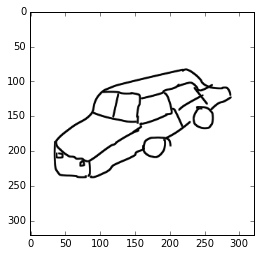

In [18]:
segO, poseO = sketchPTseg('3655.png', 'car')
print np.argmax(poseO)+1

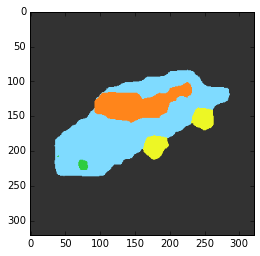

In [19]:
plt.imshow(make_color(segO))

### Re-ranking with RRWM

In [20]:
# %load graphUtils.py

# required imports
import scipy.io 
from matplotlib import pyplot as plt
import cv2, itertools
import numpy_indexed as npi
import networkx as nx
# import graphsim as gs
from scipy.ndimage import measurements
from scipy.spatial.distance import pdist
from glob import glob
import numpy as np
import os

In [21]:
# Start and connect to MATLAB
import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath(eng.genpath('fgm-master/'), nargout=0)

In [22]:
foo=['cow-0','horse-1', 'cat-2','dog-3','sheep-4','bus-5','car-6','bicycle-7', 'motorbike-8','bird-9','aeroplane-10']
# foo=['cat-0','dog-1','sheep-2']
class2idx = {}
idx2class = {}
for item in foo:
    key, val = item.split("-", 1)
    class2idx[key] = int(val)
    idx2class[int(val)] = key

In [23]:
def num2oneHot(num, maxClasses=3):
    oneHot = np.zeros(maxClasses)
    oneHot[num] = 1
    return oneHot

In [24]:
oneHotMap = {}
for classLabel, classIdx in class2idx.items():
    oneHotMap[classIdx] = num2oneHot(classIdx, len(foo))

In [25]:
im2class = {}
listDir = '../exp-src/data/lists/train_val_lists/'
for classLabel, classIdx in class2idx.items():
    imListFile = os.path.join(listDir, 'chosen_train_'+ classLabel +'_list.txt')
    with open(imListFile, 'r') as f:
        for line in f:
            line = line.strip()
            imId = line.split('(')[0]
            im2class[imId] = oneHotMap[classIdx]
#     print classLabel, classIdx

In [26]:
# Part info
Parts = {}
Parts['aeroplane'] = ['body', 'wheels', 'tail', 'engine', 'wings', 'dont care1']
Parts['bird'] = ['body','leg','tail','dont care1','wings','head']
Parts['bicycle'] = ['wheel','saddle','handlebar','body']
Parts['bus'] = ['body','mirror','window','wheel','headlight','door']
Parts['car'] = ['body','mirror','window','wheel','headlight','door']
Parts['cat'] = ['head',  'body', 'leg', 'tail']
Parts['cow'] = ['head',  'body', 'leg', 'tail']
Parts['dog'] = ['head', 'body', 'leg', 'tail']
Parts['horse'] = ['head',  'body', 'leg', 'tail']
Parts['motorbike'] = ['wheel','saddle','handlebar','body']
Parts['sheep'] = ['head', 'body',  'leg', 'tail']

# Parts[0] = ['head',  'body', 'leg', 'tail']
# Parts[1] = ['head',  'body', 'leg', 'tail']
# Parts[2] = ['body','mirror','window','wheel','headlight','door']
# Parts[3] = ['wheel','saddle','handlebar','body']
# Parts[4] = ['body', 'leg/wheels', 'tail', 'engine', 'wings', 'head']


labelList = Parts.keys()
ctr = 0
part2idx = {}
idx2part = {}


for label in sorted(labelList):
    part2idx[label] = {}
    for part in Parts[label]:
        part2idx[label][part] = ctr
        idx2part[ctr] = (label, part)
        ctr +=1

foo=['cow-0','horse-1', 'cat-2','dog-3','sheep-4','bus-5','car-6','bicycle-7', 'motorbike-8','bird-9','aeroplane-10']
class2idx = {}
idx2class = {}
for item in foo:
    key, val = item.split("-", 1)
    class2idx[key] = int(val)
    idx2class[int(val)] = key

imId2classId = {}
# Make retrieval dict
with open('./train_val_retrieval.txt') as f:
    while(1):
        x = f.readline()
        if not x:
            break
        path, label = x.split(' ')
        imId = os.path.splitext(os.path.basename(path))[0]
        imId2classId[imId] = idx2class[int(label)]

In [27]:
class2idx = {}
idx2class = {}
for item in foo:
    key, val = item.split("-", 1)
    class2idx[key] = int(val)
    idx2class[int(val)] = key
# Super classes:
class2superClass = {}
class2superClass[0] = 0
class2superClass[1] = 0
class2superClass[2] = 1
class2superClass[3] = 1
class2superClass[4] = 1
class2superClass[5] = 2
class2superClass[6] = 2
class2superClass[7] = 3
class2superClass[8] = 3
class2superClass[9] = 4
class2superClass[10] = 4

## WARNING: Huge code-block ahead

The code block below contains most of the graph-construction code. Just execute and skip ahead.

In [32]:
def getNodes(mask, classLabel, display=False):
    '''
    For a given mask return all possible nodes and their attributes
    '''
    if display:
        plt.imshow(mask)
    nodes = {}
    instanceMap = np.zeros(mask.shape, dtype=np.int64)
    cumRegions = 0
    numParts = np.unique(mask)[1:]
    h, w = mask.shape
    Nt = h*w
    Nb = len(mask[mask==0])
    

    for k in numParts: # iterate through all parts present
        temp = mask.copy()
        temp[mask!=k] = 0
       
        lw, num = measurements.label(temp)
        lw[lw!=0] += cumRegions
        instanceMap += lw

        if display:
            plt.figure()
            plt.imshow(lw)

        # get distinct instances of each part and their location + area
        regions = np.unique(lw)[1:]
        areas = measurements.sum(temp, lw, index=np.arange(cumRegions, np.max(lw) + 1))[1:]
        centres = measurements.center_of_mass(temp, lw, regions)
        for region, area, centre in zip(regions, areas, centres):
            areaNorm = area/k
            nodeDict = {'area': areaNorm/Nt\
                        ,'areaB':areaNorm/Nb\
                        ,'areaF':areaNorm/(Nt-Nb)\
                        ,'cx': (centre[1]-w/2)/(w/2)\
                        ,'cy': -(centre[0]-h/2)/(h/2)\
                        ,'Cx': (centre[1])\
                        ,'Cy': (centre[0])\
                        ,'theta':math.degrees(math.atan2(-(centre[0]-(h/2)), (centre[1]-(w/2))))\
                        ,'label': Parts[classLabel][k-1]\
                        ,'instanceLabel': region\
                       }
            nodes[region] = nodeDict
        cumRegions += len(regions)
    return nodes, instanceMap


def sketch2graph(mask, classLabel=None, display=False, globalOnly=0, mergeInstances=False, qmulD=True):
    '''
    For a given sketch return a graph object.
    Can display.
    '''
    
    h, w = mask.shape
    diag = np.hypot(h,w)
    # Get part histogram
#     partHist = sketch2hist(mask)
    
    # Graph init
    G=nx.Graph()
    parts, counts = np.unique(mask, return_counts=True)
    Nb = counts[0]
    Nt = np.sum(counts)
    if Nb == Nt:    # Mask is empty, add only global node
        G.add_node(0, attr_dict={'Nb':Nb, 'Nt':Nt, 'label':classLabel, 'parts':[0]*len(idx2part)})#, classLabel=class2idinstanceMap[label], partsPresent=nodes)
        return

    parts = parts[1:]; counts = counts[1:] # drop background

    # Get all part nodes (instances separate)
    nodes, instanceMap = getNodes(mask, classLabel, False)
    
    partsPresent = np.unique(mask)
    
    # Find all neighbors and add edges
    neighbors = np.concatenate([instanceMap[:, :-1].flatten(), instanceMap[:, +1:].flatten(), instanceMap[+1:, :].flatten(), instanceMap[:-1, :].flatten()])
    centers   = np.concatenate([instanceMap[:, +1:].flatten(), instanceMap[:, :-1].flatten(), instanceMap[:-1, :].flatten(), instanceMap[+1:, :].flatten()])
    valid = neighbors != centers
    regions, neighbors_per_regions = npi.group_by(centers[valid], neighbors[valid])
    neighborDict = {}
    for region, neighbors_per_region in zip(regions, neighbors_per_regions):
        if region == 0:
            continue
#         print(region)
        unique_neighbors, neighbor_counts = npi.count(neighbors_per_region)
        neighborDict[region] = unique_neighbors.tolist()
        eNeighbors = zip(unique_neighbors, np.repeat(region, unique_neighbors.shape[0]))
#         print(unique_neighbors, neighbor_counts / neighbor_counts.sum() * 100)
        G.add_edges_from(eNeighbors)
        G.add_node(region, nodes[region])
        
    # Drop very small nodes
    G.remove_node(0) # remove cuz no area
    dropper = [node for node, data in G.nodes(data=True) if data['area']<0.0001]
    G.remove_nodes_from(dropper)
        
    # TODO : Add all edge attributes
    for u,v,a in G.edges(data=True):
        G[u][v]['dist'] = np.linalg.norm(np.array(G.node[u]['cx'], G.node[u]['cy'])-np.array(G.node[v]['cx'], G.node[v]['cy']))/diag
        G[u][v]['delx'] = (G.node[u]['cx']-G.node[v]['cx'])*np.sign(G.node[u]['instanceLabel']-G.node[v]['instanceLabel'])
        G[u][v]['dely'] = (G.node[u]['cx']-G.node[v]['cx'])*np.sign(G.node[u]['instanceLabel']-G.node[v]['instanceLabel'])
        G[u][v]['angle'] = math.atan2(G.node[v]['cy']-G.node[u]['cy'], G.node[v]['cx']-G.node[u]['cx'])
    
    # Remove bg and add global node
    partHist = np.zeros((len(idx2part)))
    for node in G.nodes():
        partHist[part2idx[classLabel][G.node[node]['label']]] += 1
    
    G.add_node(0, attr_dict={'Nb':Nb, 'Nt':Nt, 'label':classLabel, 'partHist':partHist.tolist(), 'area':Nt-Nb, 'h':h, 'w':w})#, classLabel=class2idinstanceMap[label], partsPresent=nodes)

    # Drop everything, re-add global
    if globalOnly==1:
        G.clear()
        G.add_node(0, attr_dict={'Nb':Nb, 'Nt':Nt, 'label':classLabel, 'partHist':partHist.tolist(), 'area':Nt-Nb})#, classLabel=class2idinstanceMap[label], partsPresent=nodes)
    elif globalOnly==2:
        for nodeIdx in G.nodes()[1:]:
            if G.node[nodeIdx]['label'] != 'body':
#                 print 'removing ' + G.node[nodeIdx]['label']
                G.remove_node(nodeIdx)
                
    # Re-label after dropping
    nodeIdxList = sorted(G.nodes())
    relabelDict = {old: new for old, new in zip(nodeIdxList, range(len(nodeIdxList)))}
    G = nx.relabel_nodes(G, relabelDict)
        
    # add neighbor hist
    minIdx = min(part2idx[classLabel].values())
    for node in G.nodes()[1:]:
        nbHist = [0]*(len(part2idx[classLabel]) + 1)
        for neighbor in G[node].keys():
            if neighbor == 0:
                continue
            idx = part2idx[classLabel][G.node[neighbor]['label']] - minIdx
#             print part2idx[classLabel][G.node[neighbor]['label']], classLabel, G.node[neighbor]['label']
            nbHist[idx] += 1
        G.node[node]['nbHist'] = nbHist
    
    # Connect global to all existing nodes - NO NEED FOR THIS
#     nodeIdxList = sorted(G.nodes())
#     for nodeIdx in nodeIdxList[1:]:
#         x, y = G.node[nodeIdx]['centre']
#         G.add_edge(0, nodeIdx, Cx=x,\
#                    Cy=y,\
#                    theta= np.arctan(y/x) \
#                   )
    
    # Draw graph
    if display:
        pos = nx.spring_layout(G)
        nx.draw(G, pos)
        node_labels = nx.get_node_attributes(G,'label')
        nx.draw_networkx_labels(G, pos, labels = node_labels)
        edge_labels = nx.get_edge_attributes(G,'absPos')
        nx.draw_networkx_edge_labels(G, pos, labels = edge_labels)
        plt.show()
#         plt.axis('off')
#         plt.imshow(sketchImg)
#         plt.figure()
#         plt.axis('off')
#         plt.imshow(mask)
        plt.figure()
        plt.axis('off')
        plt.imshow(instanceMap)
    return G



def im2graph(mask, classLabel=None, display=False, globalOnly=0, mergeInstances=False):
    '''
    For a given image return a graph object.
    Can display or merge all instances of parts into one node in needed
    '''
#     mask = cv2.imread(gtFile, 0)
    h, w = mask.shape
    diag = np.hypot(h,w)

    # Graph init
    G=nx.Graph()
    parts, counts = np.unique(mask, return_counts=True)
    Nb = counts[0]
    Nt = np.sum(counts)
    if Nb == Nt:    # Mask is empty, add only global node
        G.add_node(0, attr_dict={'Nb':Nb, 'Nt':Nt, 'label':classLabel, 'partHist':[0]*len(idx2part)})#, classLabel=class2idinstanceMap[label], partsPresent=nodes)
        return

    parts = parts[1:]; counts = counts[1:] # drop background
    
    # Get all part nodes (instances separate)
    nodes, instanceMap = getNodes(mask, classLabel, False)
    partsPresent = np.unique(mask)
    
    # Find all neighbors and add edges
    neighbors = np.concatenate([instanceMap[:, :-1].flatten(), instanceMap[:, +1:].flatten(), instanceMap[+1:, :].flatten(), instanceMap[:-1, :].flatten()])
    centers   = np.concatenate([instanceMap[:, +1:].flatten(), instanceMap[:, :-1].flatten(), instanceMap[:-1, :].flatten(), instanceMap[+1:, :].flatten()])
    valid = neighbors != centers
    regions, neighbors_per_regions = npi.group_by(centers[valid], neighbors[valid])
    neighborDict = {}
    for region, neighbors_per_region in zip(regions, neighbors_per_regions):
        if region == 0:
            continue
#         print(region)
        unique_neighbors, neighbor_counts = npi.count(neighbors_per_region)
        neighborDict[region] = unique_neighbors.tolist()
        eNeighbors = zip(unique_neighbors, np.repeat(region, unique_neighbors.shape[0]))
#         print(unique_neighbors, neighbor_counts / neighbor_counts.sum() * 100)
        G.add_edges_from(eNeighbors)
        G.add_node(region, nodes[region])
        G.node[region]['nbHist'] = unique_neighbors
    
    # Drop very small nodes
    G.remove_node(0) # remove cuz no area
    dropper = [node for node, data in G.nodes(data=True) if data['area']<0.0001]
    G.remove_nodes_from(dropper)
        

    # Remove bg and add global node
    # Compute part histogram
    partHist = np.zeros((len(idx2part)))
    for node in G.nodes():
        partHist[part2idx[classLabel][G.node[node]['label']]] += 1
    
    G.add_node(0, attr_dict={'Nb':Nb, 'Nt':Nt, 'label':classLabel, 'partHist':partHist.tolist(), 'area':Nt-Nb, 'h':h, 'w':w})#, classLabel=class2idinstanceMap[label], partsPresent=nodes)

    # TODO : Add all edge attributes
    for u,v,a in G.edges(data=True):
        G[u][v]['dist'] = np.linalg.norm(np.array(G.node[u]['cx'], G.node[u]['cy'])-np.array(G.node[v]['cx'], G.node[v]['cy']))/diag
        G[u][v]['delx'] = (G.node[u]['cx']-G.node[v]['cx'])*np.sign(G.node[u]['instanceLabel']-G.node[v]['instanceLabel'])
        G[u][v]['dely'] = (G.node[u]['cx']-G.node[v]['cx'])*np.sign(G.node[u]['instanceLabel']-G.node[v]['instanceLabel'])
        G[u][v]['angle'] = math.atan2(G.node[v]['cy']-G.node[u]['cy'], G.node[v]['cx']-G.node[u]['cx'])
    
    # Drop everything, re-add global FOR EXPERIMENTS
    if globalOnly==1:
        G.clear()
        G.add_node(0, attr_dict={'Nb':Nb, 'Nt':Nt, 'label':classLabel, 'partHist':partHist.tolist(), 'area':Nt-Nb, 'h':h, 'w':w})#, classLabel=class2idinstanceMap[label], partsPresent=nodes)
    elif globalOnly==2:
        for nodeIdx in G.nodes()[1:]:
            if G.node[nodeIdx]['label'] != 'body':
#                 print 'removing ' + G.node[nodeIdx]['label']
                G.remove_node(nodeIdx)
                
    # Sort after re-labeling
    nodeIdxList = sorted(G.nodes())
    relabelDict = {old: new for old, new in zip(nodeIdxList, range(len(nodeIdxList)))}
    G = nx.relabel_nodes(G, relabelDict)
    
    # add neighbor hist
    minIdx = min(part2idx[classLabel].values())
    for node in G.nodes()[1:]:
        nbHist = [0]*(len(part2idx[classLabel])+1)
        for neighbor in G[node].keys():
            if neighbor == 0:
                continue
            idx = part2idx[classLabel][G.node[neighbor]['label']] - minIdx
#             print part2idx[classLabel][G.node[neighbor]['label']], classLabel, G.node[neighbor]['label']
            nbHist[idx] += 1 # Count rather than one-hot
        G.node[node]['nbHist'] = nbHist
    
    # Connect global to all existing nodes
#     nodeIdxList = sorted(G.nodes())
#     for nodeIdx in nodeIdxList[1:]:
#         x, y = G.node[nodeIdx]['centre']
#         G.add_edge(0, nodeIdx, Cx=x,\
#                    Cy=y,\
#                    theta= np.arctan(y/x) \
#                   )
    
    # Draw graph
    if display:
        pos = nx.spring_layout(G)
        nx.draw(G, pos)
        node_labels = nx.get_node_attributes(G,'label')
        nx.draw_networkx_labels(G, pos, labels = node_labels)
        edge_labels = nx.get_edge_attributes(G,'absPos')
        nx.draw_networkx_edge_labels(G, pos, labels = edge_labels)
        plt.show()
        plt.axis('off')
        plt.imshow(img)
#         plt.figure()
#         plt.axis('off')
#         plt.imshow(mask)
        plt.figure()
#         plt.axis('off')
        plt.imshow(instanceMap)
    return G

def constructK(G1, G2):
    '''
    Given two graphs calculate the affinity matrix
    '''
    n1, n2 = len(G1), len(G2)
#     print n1, n2, n1*n2
    K = np.zeros((n1*n2, n1*n2), dtype = float)
    Ktemp = np.zeros((n1*n2, n1*n2), dtype = float)
#     print K.shape
    for i1 in range(1, n1+1):
        for i2 in range(1, n2+1):
            for j1 in range(1, i1+1):
                for j2 in range(1, i2+1):
                # Iterate with (i2+(i1-1)*n2,j2+(j1-1)*n2)
                    if i1==j1 and i2==j2:
                    # Compute node affinities
                        if i1==n1 and i2==n2:
                            # Global node: compute part histogram similarity
#                             continue
                            partHistVec = np.vstack((np.asarray(G1.node[0]['partHist']), np.asarray(G2.node[0]['partHist'])))
                            Ktemp[i2+n2*(i1-1)-1,j2+n2*(j1-1)-1] = 1-pdist(partHistVec, metric='jaccard')
#                             print 1-pdist(partHistVec, metric='jaccard')
                        elif i1==n1 or i2==n2:
                            # Local node vs global node: skip ill defined
                            continue
                        else:
#                             continue
                            # Local-local nodes compute feature vector distance
                            v1 = np.asarray((
#                                              G1.node[i1]['areaF'],\
#                                              G1.node[i1]['cx'],\
#                                              G1.node[i1]['cy'],\
                                             G1.node[i1]['theta']\
                                            ))
                            v2 = np.asarray((
#                                              G2.node[i2]['areaF'],\
#                                              G2.node[i2]['cx'],\
#                                              G2.node[i2]['cy'],\
                                             G2.node[i2]['theta']\
                                            ))
#                             print 1-pdist(np.vstack((v1,v2)), metric='cosine')
                            if G1.node[i1]['label']!=G2.node[i2]['label']:
                                continue
                            nbSim = sum(i[0] * i[1] for i in zip(G1.node[i1]['nbHist'], G2.node[i2]['nbHist']))/len(G1.node[i1]['nbHist'])
                            nbSim = 0
#                             Ktemp[i2+(i1-1)*n2-1,j2+(j1-1)*n2-1] = (1 - pdist(np.vstack((v1,v2)), metric='cosine')+nbSim)*\
#                                                                     (G1.node[i1]['areaF']*G2.node[i2]['areaF'])
                            Ktemp[i2+(i1-1)*n2-1,j2+(j1-1)*n2-1] = 1 - (abs(v1-v2)/180 if abs(v1-v2) < 180 else (abs(v1-v2)-180)/180)
#                             print G2.node[i2]['label'], Ktemp[i2+(i1-1)*n2-1,j2+(j1-1)*n2-1]
                            
                    elif i1!=j1 and i2!=j2:
                        # Compute edge affintities
                        if (i1==n1 or j1==n1) or (i2==n2 or j2==n2):
                            # Skip if one of the nodes is global
                            continue
                        else:
                            # Compute for local-local edges
                            if G1.has_edge(i1, j1) and G2.has_edge(i2, j2):
#                                 continue
#                                 v1 = np.asarray((G1.edge[i1][j1]['delx'], G1.edge[i1][j1]['dely'], G1.edge[i1][j1]['angle']))
#                                 v2 = np.asarray((G2.edge[i2][j2]['delx'], G2.edge[i2][j2]['dely'], G2.edge[i2][j2]['angle']))
#                                 v1 = np.asarray((G1.edge[i1][j1]['angle']))
#                                 v2 = np.asarray((G2.edge[i2][j2]['angle']))
#                                 print v1, v2
                                v1 = np.asarray((G1.edge[i1][j1]['delx'], G1.edge[i1][j1]['dely']))
                                v2 = np.asarray((G2.edge[i2][j2]['delx'], G2.edge[i2][j2]['dely']))
                                Ktemp[i2+(i1-1)*n2-1,j2+(j1-1)*n2-1] = (1-pdist(np.vstack((v1,v2)), metric='cosine'))\
                                    *G1.node[i1]['areaF']*G2.node[i2]['areaF']*G1.node[j1]['areaF']*G2.node[j2]['areaF']

        # K is symmetric
        K = Ktemp+Ktemp.T-np.diag(np.diag(Ktemp));
    return K

def constructCt(G1, G2):
    '''
    Given 2 graphs, encode constraints:
    1. Global matching allowed only to other global
    2. Non-global matching allowed to corresponding parts
    '''
    n1, n2 = len(G1), len(G2)
    Ct = np.zeros((n1, n2), dtype = int)
    G1nodes = nx.get_node_attributes(G1, 'label')
    G2nodes = nx.get_node_attributes(G2, 'label')
    if G1nodes[0] != G2nodes[0]: 
        # Allow matching only if both graphs are from same class
        return Ct
    
    for i,j in itertools.product(G1nodes.keys(), G2nodes.keys()):
        # Allow matching if parts have same classes
        if G1nodes[i] == G2nodes[j]:
            Ct[i, j] = 1
    
#     Ct = np.ones((n1, n2))
    return Ct

def graphMatch(G1, G2):
    if not G1 or not G2:
        return -sys.maxint

    # Convert K and Ct to MATLAB format
    K = matlab.double(constructK(G1, G2).tolist())
    Ct = matlab.double(constructCt(G1, G2).tolist())
    
    score = eng.matchGraphs(K, Ct)
#     print 'similarity score :', eng.matchGraphs(K, Ct)
    return score

## Qualitative results

In [29]:
def reRankQuant(imList, querySegmap, classLabel):
    '''
    Re-rank a sketch-based image retrieval list for quantitative eval
    '''
    # compute a "score" for each image based on RRWM and re-rank by sorting
    reRankList = []
    
    # Query meta data 
    # change this, too volatile
#     classLabel = os.path.basename(os.path.dirname(queryPath))
#     queryName = os.path.basename(queryPath)
#     querySMpath = os.path.join('/data1/abhijat/SOPS/QMUL_FGR/Data/Test/segmentations/retrieval_sketch/', classLabel, queryName)
#     queryIMpath = os.path.join('/data1/abhijat/SOPS/QMUL_FGR/Data/Test/images/', classLabel, 'sketch', queryName)
#     querySegmap = cv2.imread(querySMpath, 0)
    
    # Construct graph for query
    GQ = sketch2graph(querySegmap, classLabel=classLabel)
    
    # Retrieval image meta-data (PASCAL)
#     gtDir = '../exp-src/data/pascal_parts_GT_no_aug/'
#     imDir = '../exp-src/data/PASCAL_Parts_select_png/'
    gtDir = segPaths
    imDir = photo_paths
    
    for imFile in imList:
        imId = os.path.splitext(imFile)[0]
#         print imId, imId2classId[imId]
        imFile = cv2.imread(os.path.join(imDir, imId+'.jpg'), 1)
        imSegmap = cv2.imread(os.path.join(gtDir, imId+'.png'), 0)
        
#         imPath = os.path
        G = im2graph(imSegmap, classLabel=imId2classId[imId])
        
#         G = im2graph(imFile, imDir = '/data1/abhijat/SOPS/QMUL_FGR/Data/Test/images/' + classLabel + '/img', classLabel=classLabel )
        # Match graphs 
        score = graphMatch(G, GQ)
        reRankList.append((score, imId))
    print reRankList[0]
    reRankList = sorted(reRankList)
    return reRankList

In [30]:
# rate reranking on PASCAL
def rateReranking(querySketchPath, display='False', selector=2):
    sketch_path = querySketchPath
    classLabel = os.path.basename(os.path.dirname(sketch_path))
    
    vis_dir = os.path.join('../exp-src/data/PASCAL_Parts_select_png/')
    ret_dir = vis_dir
    seg_dir = os.path.join('../exp-src/data/pascal_parts_GT_no_aug/')
    
    sketch_seg_dir = os.path.join('../exp-src/data/temp_annotation_processor/SVG/PNG_untouched/', classLabel)
    seg_path = os.path.join( '../exp-src/data/temp_annotation_processor/SVG/PNG_untouched/', classLabel, os.path.basename(sketch_path))
    
    feats, ret_list = sketchyFeatExt(ret_dir)
    
    print 'retrieving for ' + sketch_path
    sketch_in = (transformer.preprocess('data', caffe.io.load_image(sketch_path)))
    sketch_in = np.reshape([sketch_in],np.shape(sketch_net.blobs['data'].data))
    query = sketch_net.forward(data=sketch_in)
    query = np.copy(query[output_layer_sketch]) # Perform deep copy

    
    #build nn pool
    retNbrs  = NearestNeighbors(n_neighbors=np.size(feats,0), algorithm='brute',metric='cosine').fit(feats)
    #get neighbors
    distances, indices = retNbrs.kneighbors(np.reshape(query,[np.shape(query)[1]]))

    #show query
    f = plt.figure()
    plt.imshow(plt.imread(sketch_path), cmap='gray')
    plt.axis('off')
    plt.figure()
    
    querySegmap, queryPose = sketchPTseg(querySketchPath, classLabel, selector)

    plt.imshow(make_color(querySegmap))
    plt.axis('off')

    # get retrieval list
    topK = [ret_list[idx] for idx in indices[0].tolist()]
    
    # Now re-rank top 50 from the retrieval list, pick top few and evaluate
    RRS = reRankQuant(topK[:50], querySegmap, classLabel)
    

    K = 10
    if display:
        imSize = (321, 321)
        
        f , ax = plt.subplots(2, 6, figsize=(12.5, 4))
        ax[0, 0].imshow(plt.imread(sketch_path), cmap='gray')
        ax[0, 0].axis('off')
        
        ax[1, 0].imshow(make_color(querySegmap))
        ax[1, 0].axis('off')
        
                
        for i in tqdm(range(1, 6, 1)):
            ax[0,i].imshow(cv2.resize(plt.imread(ret_dir+ret_list[indices[0][i-1]]), imSize, interpolation = cv2.INTER_AREA))
            ax[0,i].axis('off')

            img = plt.imread(os.path.join(ret_dir, RRS[-i][1]+'.png'))
            ax[1,i].imshow(cv2.resize(img, imSize, interpolation = cv2.INTER_AREA))
            ax[1,i].axis('off')
            print RRS[-i][0], RRS[-i][1]

#         f.savefig('/home/babu/Documents/Retrieval/'+os.path.basename(sketch_path))

    return

In [116]:
with open('sorted_IOU_data.pkl', 'rb') as f:
    sortedSeglist = pickle.load(f)

Retrieving from 9620 photos
loading from file
retrieving for /data1/ravikiran/SketchObjPartSegmentation/data/temp_annotation_processor/SVG/PNG_untouched/dog/n02106662_24019-5.png
(0.818509165452602, '2009_000636-1')


 60%|██████    | 3/5 [00:00<00:00,  9.18it/s]

1.83227330541 2008_007471-1
1.71644805846 2010_004129-1
1.69217470109 2010_003060-1
1.3329396873 2010_003837-1


100%|██████████| 5/5 [00:00<00:00, 10.75it/s]


0.997904092115 2010_002060-1


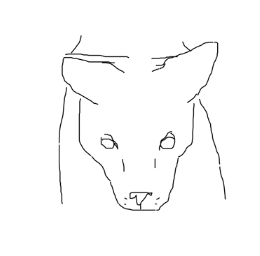

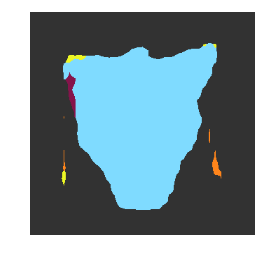

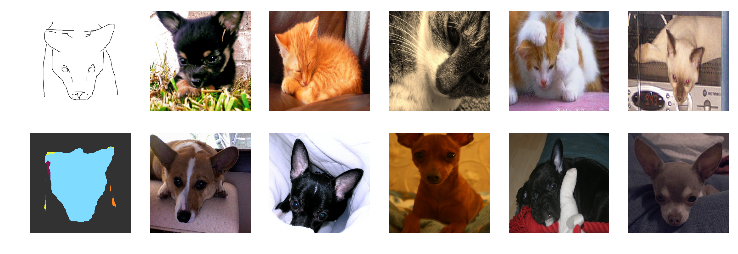

In [33]:
# getHere
rateReranking(\
'../exp-src/data/temp_annotation_processor/SVG/PNG_untouched/dog/n02106662_24019-5.png'\
              , True, 1)

The top line is Sketchy's retrievals and the bottom is our re-ranking